<a href="https://colab.research.google.com/github/aryan4codes/Basic-GAN-Model/blob/main/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch,pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [22]:
#Visualization function

def show(tensor,ch=1, size=(28,28),num=16):

  # tensor = 128 x 784  (128 img batch)
  data=tensor.detach().cpu().view(-1,ch,*size)

  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

In [23]:
#parameters

epochs = 500
cur_step=0
info_step= 300

mean_gen_loss= 0
mean_disc_loss=0

z_dim = 64
lr = 0.00001 #learning rate
loss_func= nn.BCEWithLogitsLoss()

bs = 128 #batch size

device= 'cuda'
dataloader= DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=bs)



## Declaring Models  

### 1. Generator

In [24]:
def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self,z_dim=64, i_dim= 784, h_dim=128):
    super().__init__()

    self.gen = nn.Sequential(
        genBlock(z_dim,h_dim),
        genBlock(h_dim,h_dim*2),
        genBlock(h_dim*2,h_dim*4),
        genBlock(h_dim*4,h_dim*8),
        nn.Linear(h_dim*8,i_dim), #1024 x 728 ( 28x28)
        nn.Sigmoid() #To get values from 0 to 1
          )


  def forward(self,noise):
    return self.gen(noise)


def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)


## Discriminator

def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )


class Discriminator(nn.Module):
  def __init__(self,i_dim=784,h_dim=256):
    super().__init__()
    self.disc= nn.Sequential(
        discBlock(i_dim,h_dim*4), # 784 x 1024
        discBlock(h_dim*4,h_dim*2),
        discBlock(h_dim*2,h_dim),
        nn.Linear(h_dim,1)
    )

  def forward(self,image):
    return self.disc(image)

In [25]:

gen = Generator(z_dim).to(device)
#Optimizer
gen_opt= torch.optim.Adam(gen.parameters(),lr=lr)


disc= Discriminator().to(device)
disc_opt= torch.optim.Adam(disc.parameters(),lr=lr)

In [26]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [27]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([6, 9, 5, 8, 4, 4, 0, 2, 9, 2])


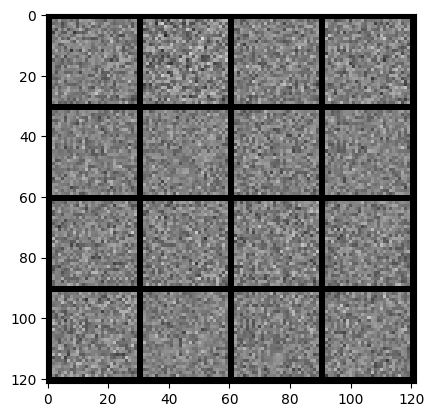

In [28]:
x,y= next(iter(dataloader))

print(x.shape,y.shape)
print(y[:10])


noise = gen_noise(bs,z_dim)
fake= gen(noise)
show(fake)

This is the initial output of passing the noise through the generator because the generator did not begin to learn yet. It produces a very noisy output

In [30]:
# Calculating loss

# gen loss

def calc_gen_loss(loss_func,gen,disc,number,z_dim):
  noise= gen_noise(number,z_dim) # 128 noise vectors

  fake= gen(noise)

  pred = disc(fake)
  targets = torch.ones_like(pred) # create a tensor of dim similar to predictions and fill it with ones for comparison
  gen_loss= loss_func(pred,targets)

  return gen_loss


#Discriminator Loss

def calc_disc_loss(loss_func,gen,disc,number,real,z_dim):
  noise = gen_noise(number,z_dim)
  fake = gen(noise)

  disc_fake= disc(fake.detach())
  disc_fake_target = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake,disc_fake_target)

  disc_real = disc(real)
  disc_real_target = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real,disc_real_target)

  disc_loss= (disc_fake_loss + disc_real_loss)/2

  return disc_loss

### Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

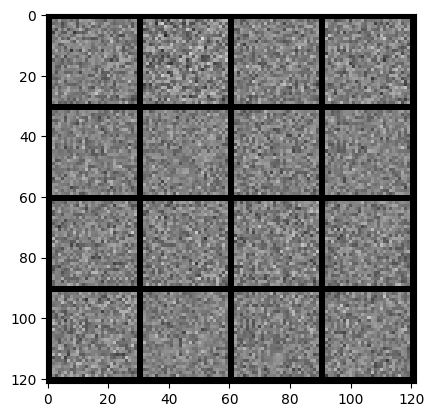

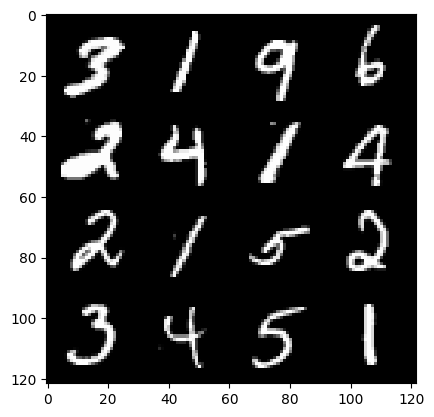

0: step 300/ Gen loss : 1.9008792185783383 / Disc Loss : 0.3389444624632597


  0%|          | 0/469 [00:00<?, ?it/s]

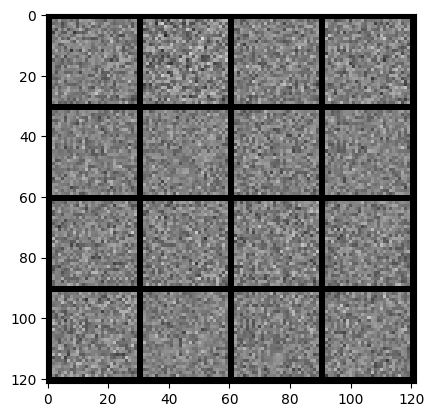

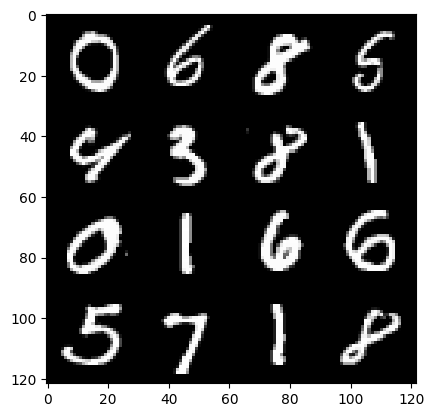

1: step 600/ Gen loss : 3.424863780339559 / Disc Loss : 0.11947566052277883


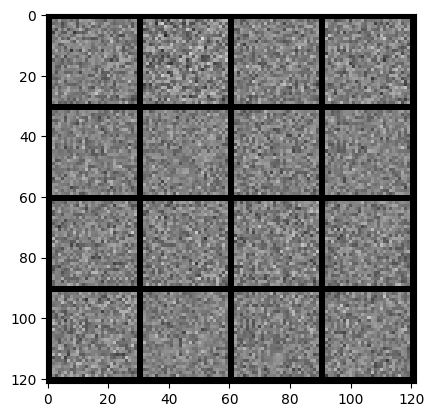

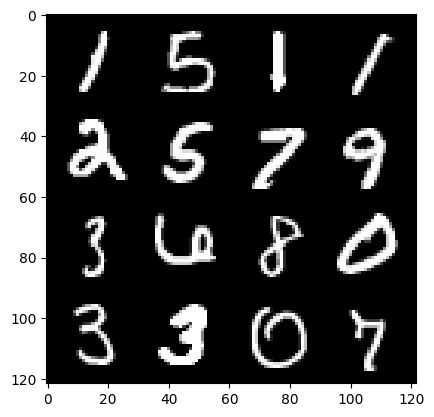

1: step 900/ Gen loss : 3.3650063610076906 / Disc Loss : 0.059171491997937385


  0%|          | 0/469 [00:00<?, ?it/s]

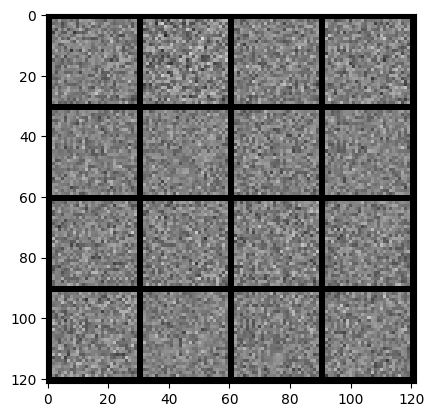

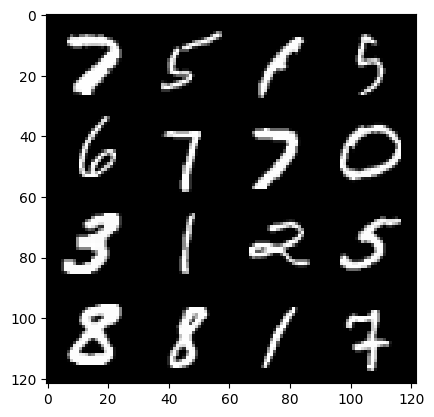

2: step 1200/ Gen loss : 3.445282689730327 / Disc Loss : 0.039970558757583305


  0%|          | 0/469 [00:00<?, ?it/s]

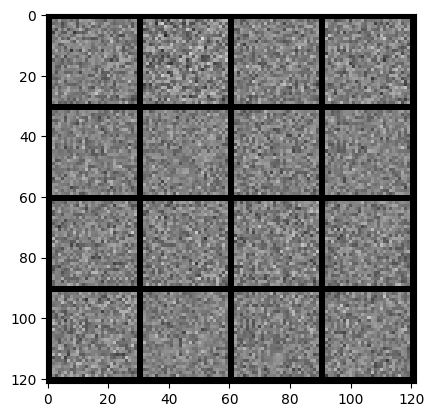

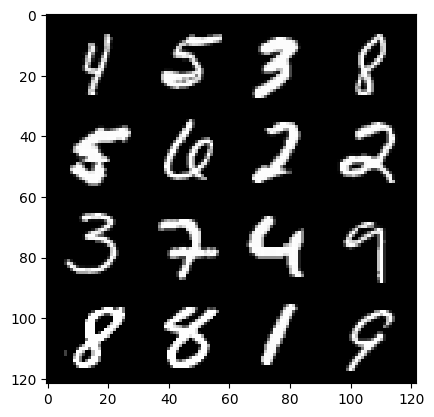

3: step 1500/ Gen loss : 3.4622861409187307 / Disc Loss : 0.03790957747027276


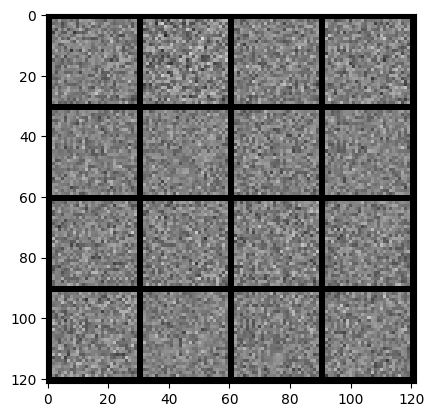

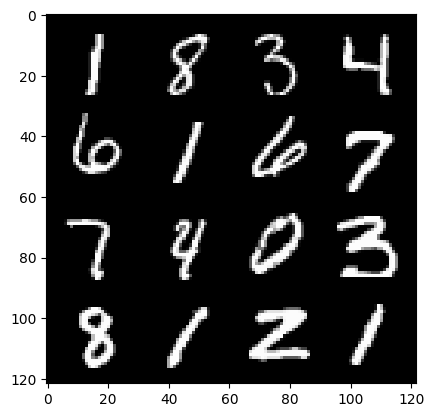

3: step 1800/ Gen loss : 3.4699274698893237 / Disc Loss : 0.04505529695500929


  0%|          | 0/469 [00:00<?, ?it/s]

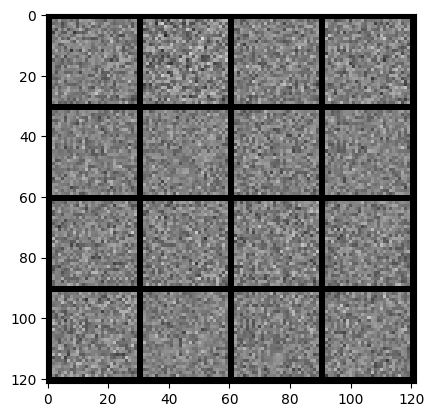

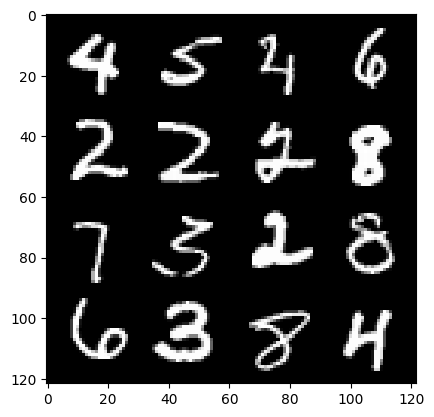

4: step 2100/ Gen loss : 3.7459427189826964 / Disc Loss : 0.04039528368040918


  0%|          | 0/469 [00:00<?, ?it/s]

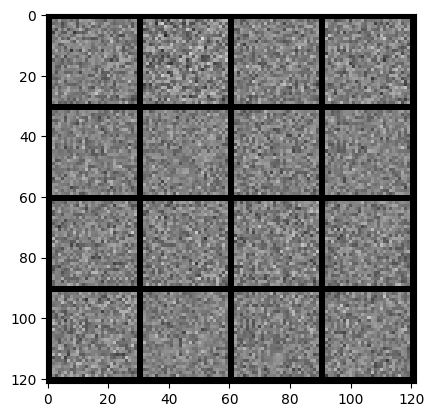

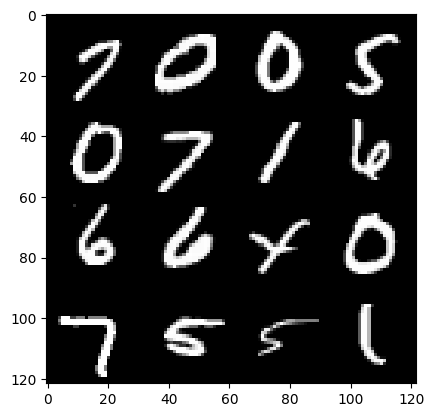

5: step 2400/ Gen loss : 3.9567657939593004 / Disc Loss : 0.03501114467158914


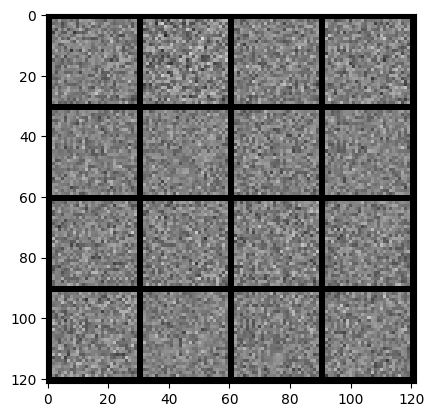

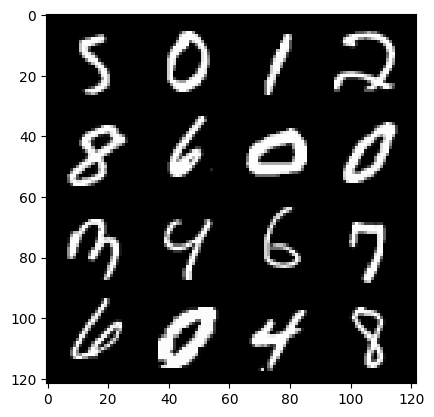

5: step 2700/ Gen loss : 4.486853477160135 / Disc Loss : 0.030109626961251117


  0%|          | 0/469 [00:00<?, ?it/s]

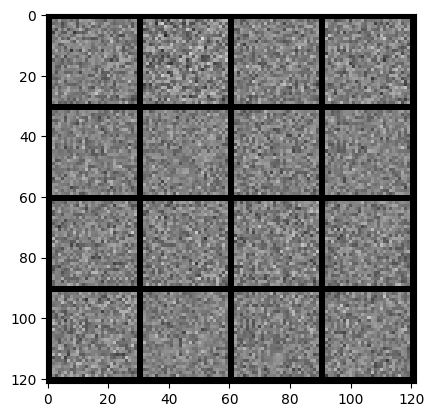

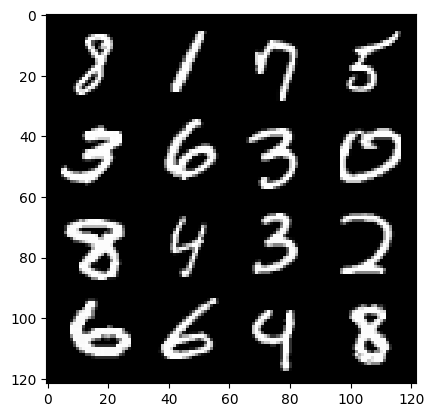

6: step 3000/ Gen loss : 4.776266304651898 / Disc Loss : 0.02691117011010648


  0%|          | 0/469 [00:00<?, ?it/s]

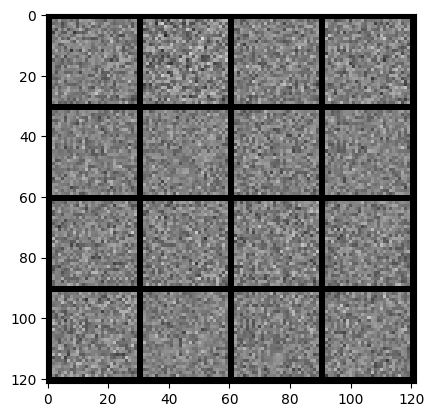

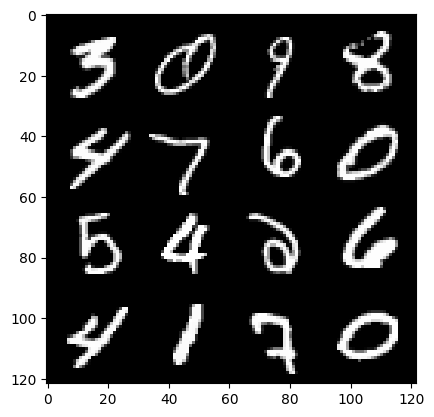

7: step 3300/ Gen loss : 4.819019165039065 / Disc Loss : 0.027694563906018932


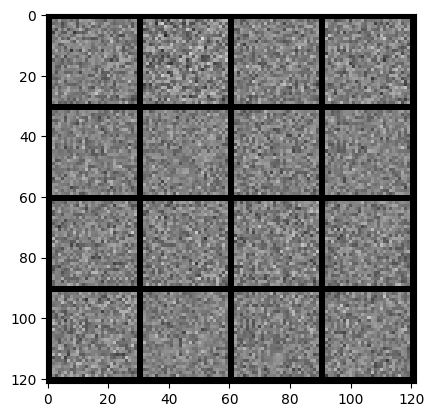

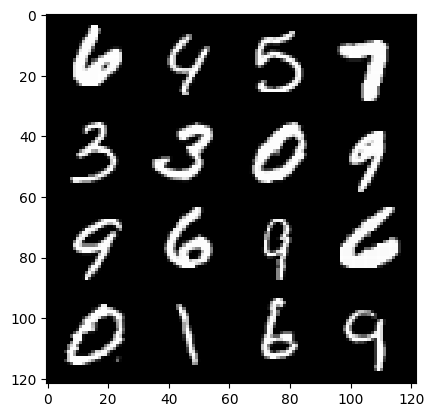

7: step 3600/ Gen loss : 4.988690148989355 / Disc Loss : 0.024754076162353148


  0%|          | 0/469 [00:00<?, ?it/s]

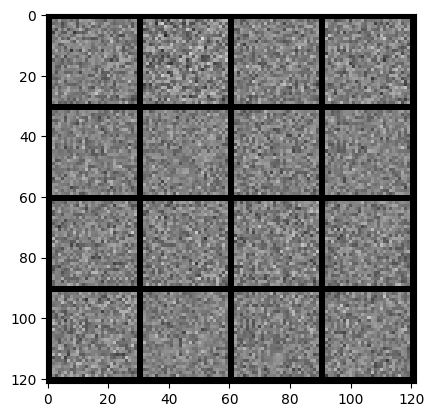

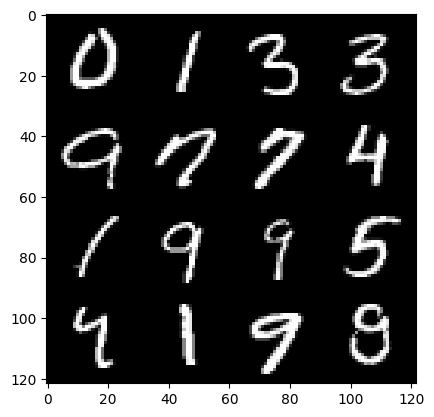

8: step 3900/ Gen loss : 5.760576004981988 / Disc Loss : 0.020576965104167646


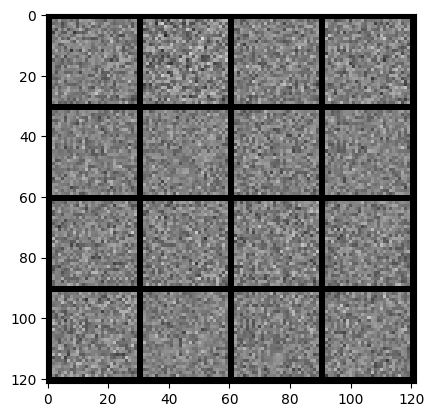

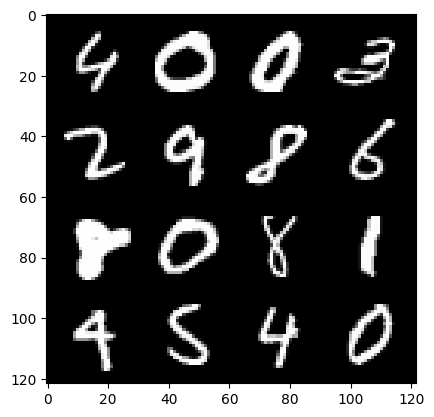

8: step 4200/ Gen loss : 5.857225116093954 / Disc Loss : 0.018804042038197313


  0%|          | 0/469 [00:00<?, ?it/s]

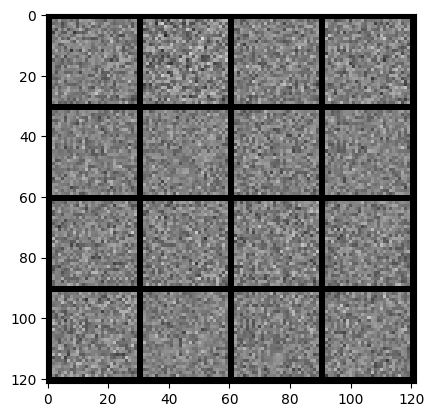

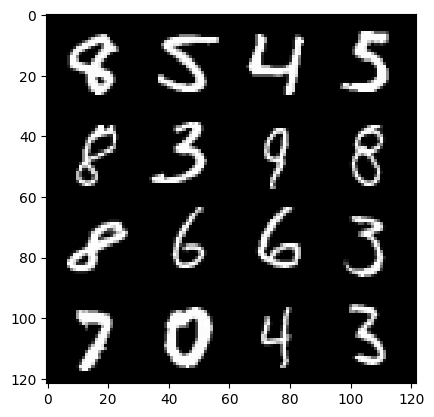

9: step 4500/ Gen loss : 5.839912365277606 / Disc Loss : 0.01701830757316203


  0%|          | 0/469 [00:00<?, ?it/s]

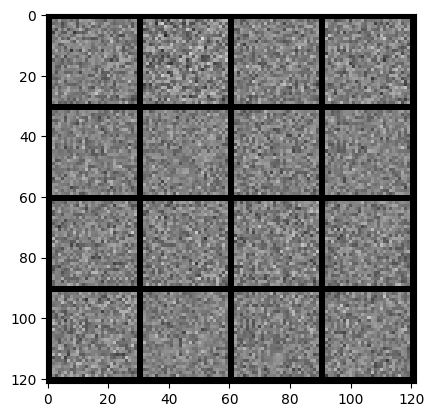

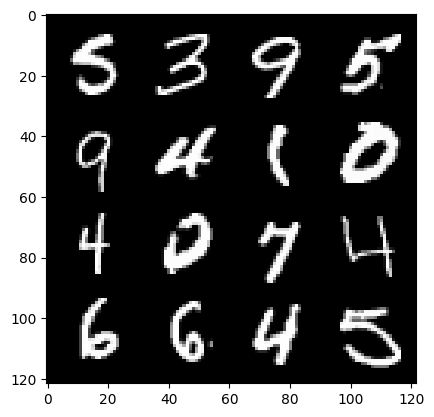

10: step 4800/ Gen loss : 5.877577503522232 / Disc Loss : 0.013180377725511798


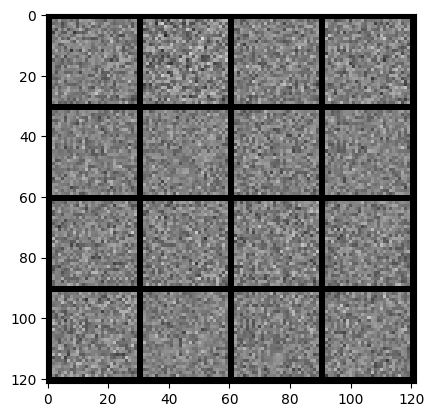

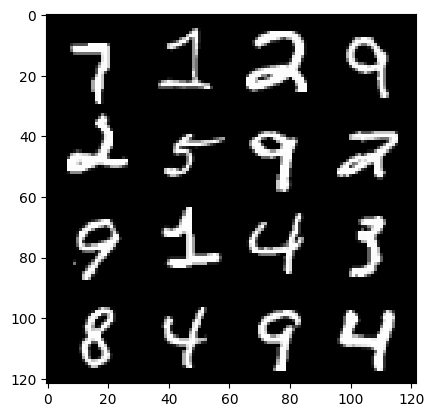

10: step 5100/ Gen loss : 6.139430600802101 / Disc Loss : 0.013039333981772278


  0%|          | 0/469 [00:00<?, ?it/s]

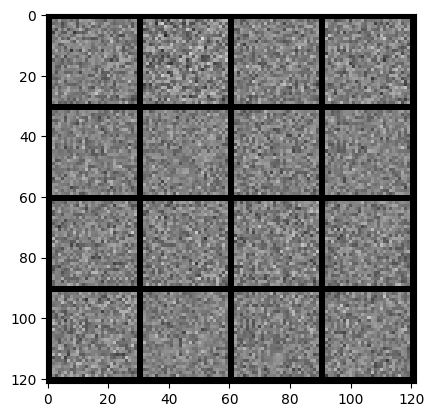

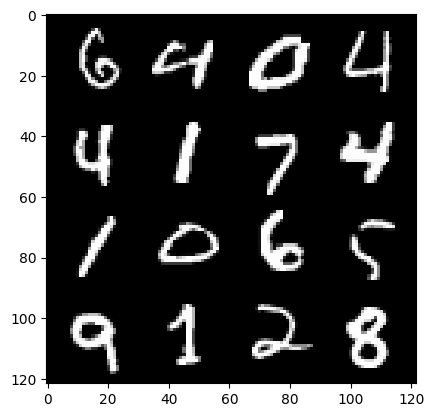

11: step 5400/ Gen loss : 6.650000432332354 / Disc Loss : 0.00979971919441596


  0%|          | 0/469 [00:00<?, ?it/s]

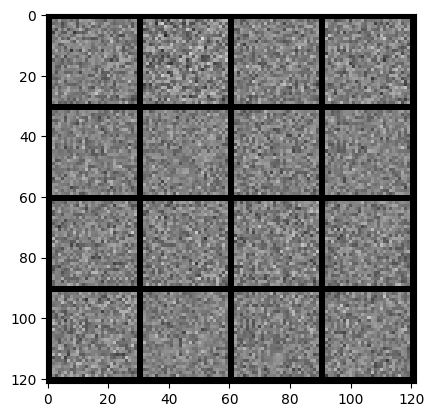

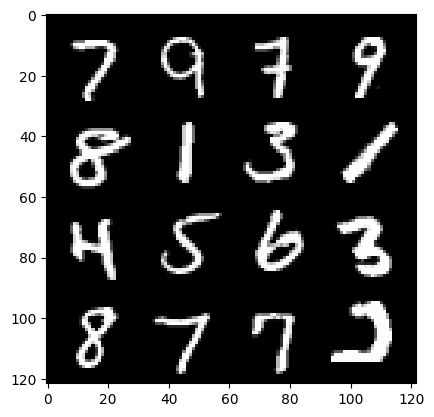

12: step 5700/ Gen loss : 6.991811084747315 / Disc Loss : 0.00969300241054347


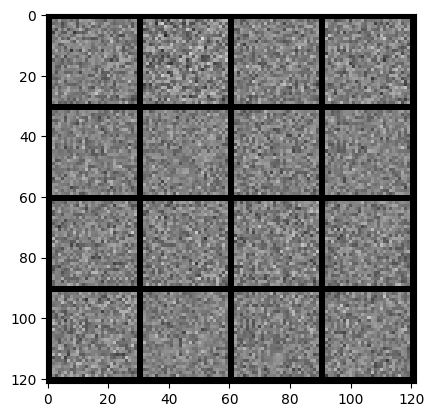

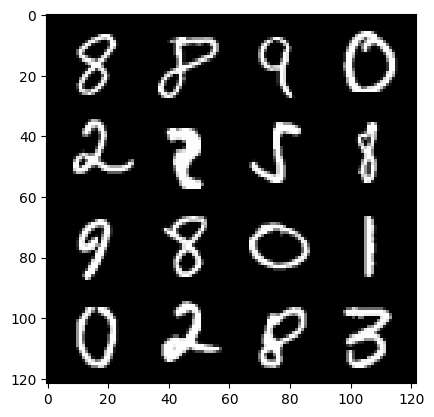

12: step 6000/ Gen loss : 6.7110556602478 / Disc Loss : 0.010454827762053654


  0%|          | 0/469 [00:00<?, ?it/s]

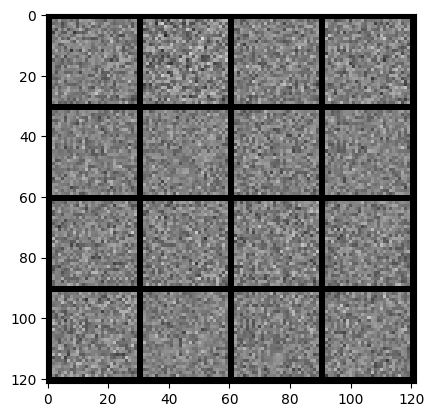

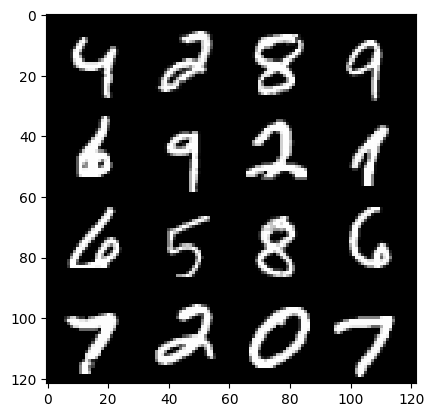

13: step 6300/ Gen loss : 6.792658940951034 / Disc Loss : 0.013386020222678778


  0%|          | 0/469 [00:00<?, ?it/s]

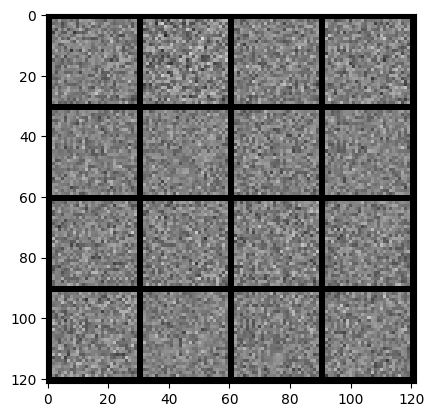

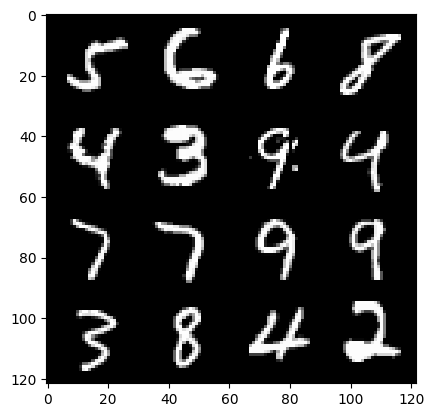

14: step 6600/ Gen loss : 6.543782742818196 / Disc Loss : 0.016197621018315362


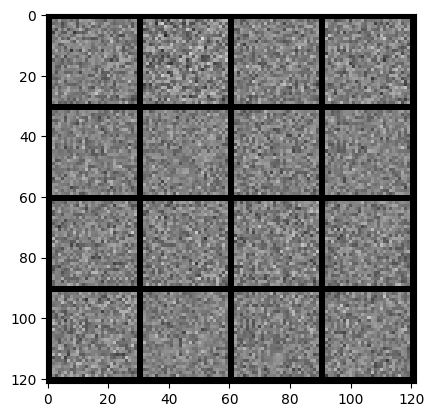

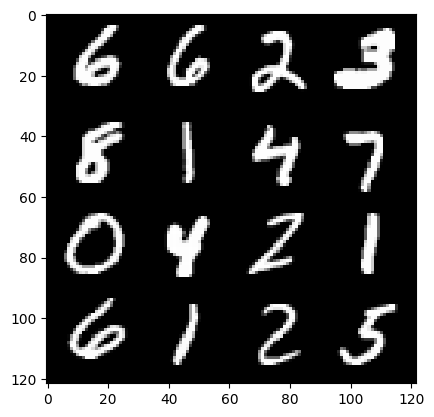

14: step 6900/ Gen loss : 6.574180035591125 / Disc Loss : 0.012407165037778521


  0%|          | 0/469 [00:00<?, ?it/s]

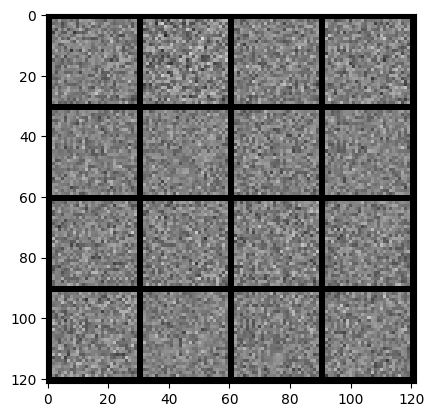

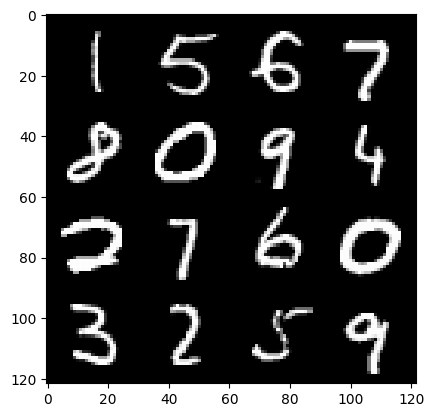

15: step 7200/ Gen loss : 6.950859378178911 / Disc Loss : 0.008495629436026015


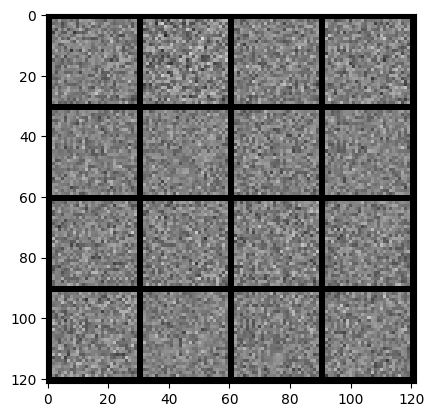

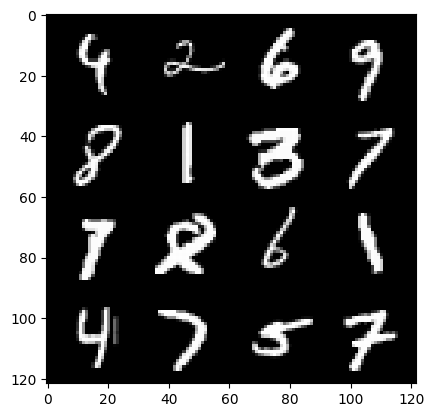

15: step 7500/ Gen loss : 6.9952730449040725 / Disc Loss : 0.007985456945995496


  0%|          | 0/469 [00:00<?, ?it/s]

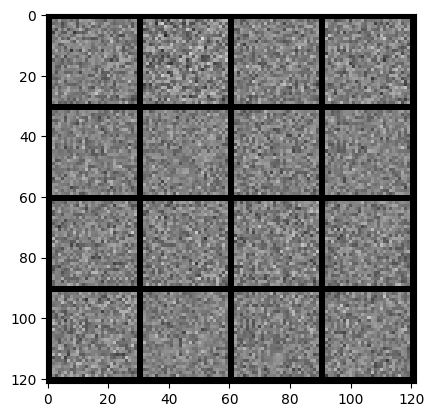

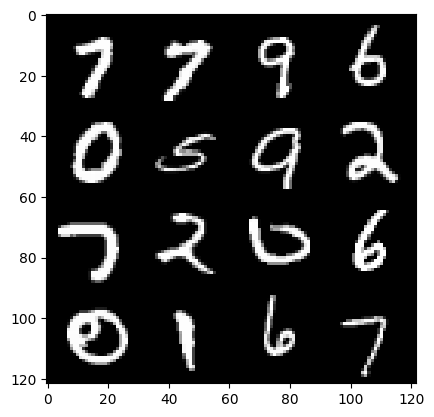

16: step 7800/ Gen loss : 6.860274333953861 / Disc Loss : 0.006910401388304309


  0%|          | 0/469 [00:00<?, ?it/s]

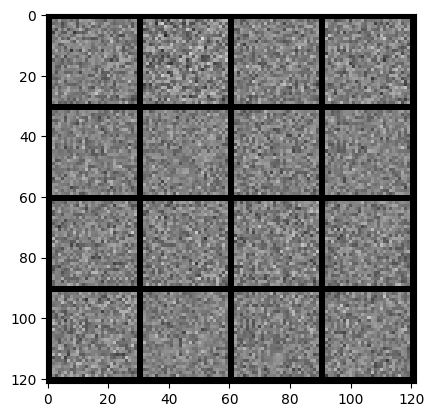

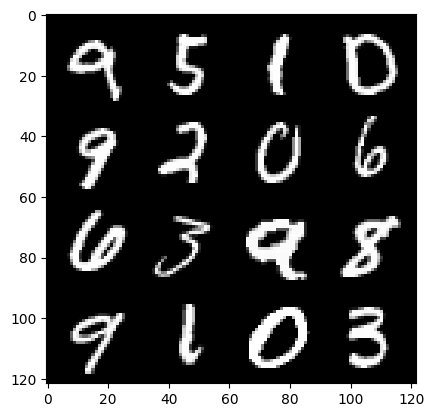

17: step 8100/ Gen loss : 7.147750023206071 / Disc Loss : 0.007658316273009406


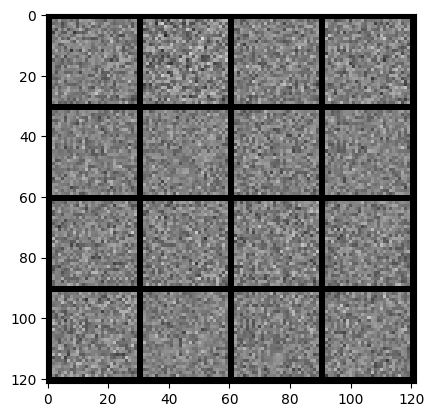

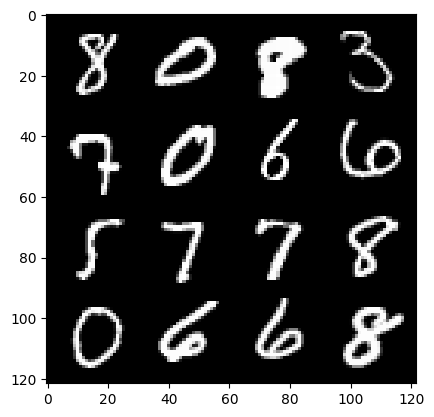

17: step 8400/ Gen loss : 7.072822141647341 / Disc Loss : 0.009197362628765408


  0%|          | 0/469 [00:00<?, ?it/s]

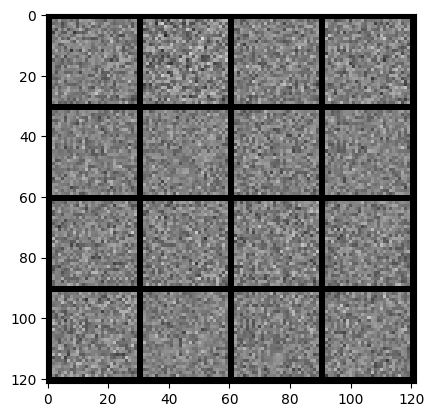

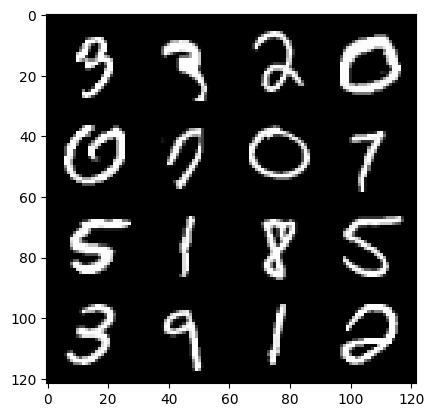

18: step 8700/ Gen loss : 7.1216616598765015 / Disc Loss : 0.010635420578376688


  0%|          | 0/469 [00:00<?, ?it/s]

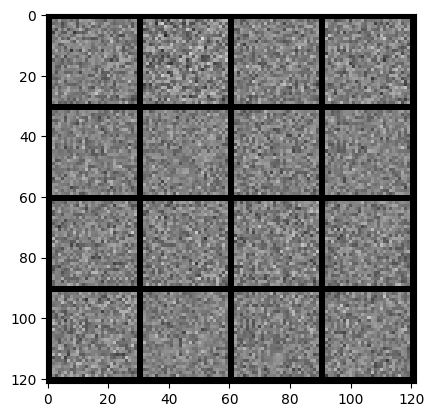

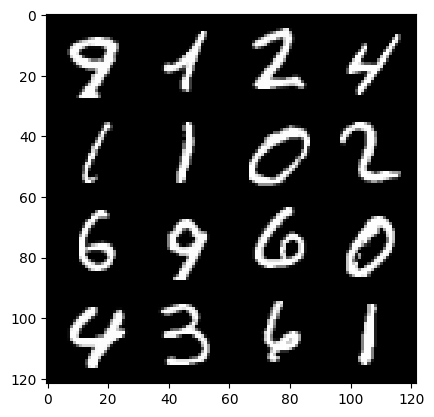

19: step 9000/ Gen loss : 7.207231993675235 / Disc Loss : 0.010674223068635911


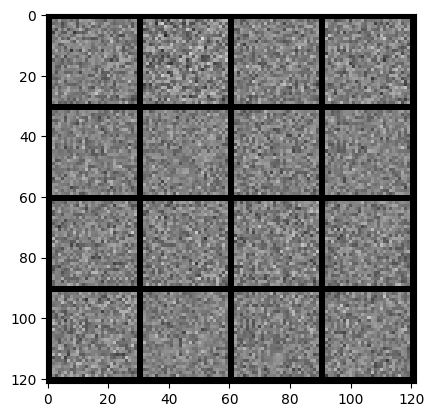

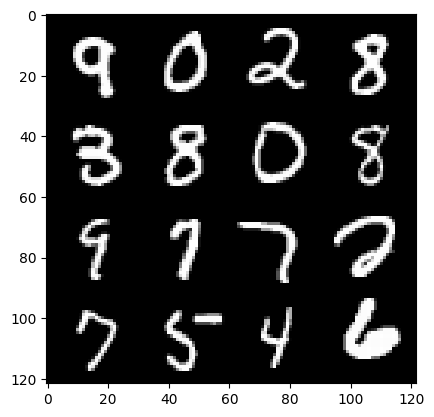

19: step 9300/ Gen loss : 7.165790529251097 / Disc Loss : 0.009884825902214896


  0%|          | 0/469 [00:00<?, ?it/s]

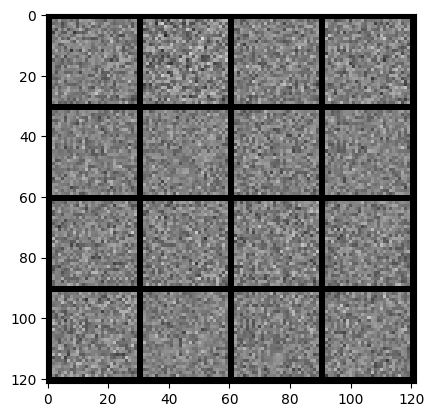

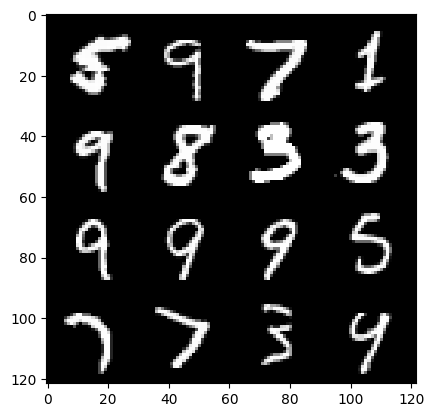

20: step 9600/ Gen loss : 7.095532196362813 / Disc Loss : 0.009752239224035293


  0%|          | 0/469 [00:00<?, ?it/s]

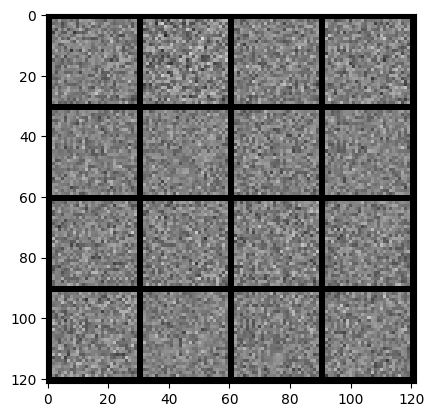

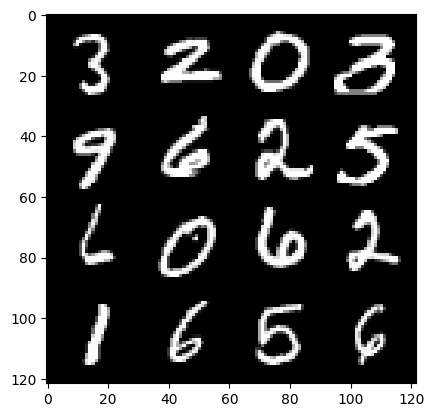

21: step 9900/ Gen loss : 6.749137713114425 / Disc Loss : 0.0097233309596777


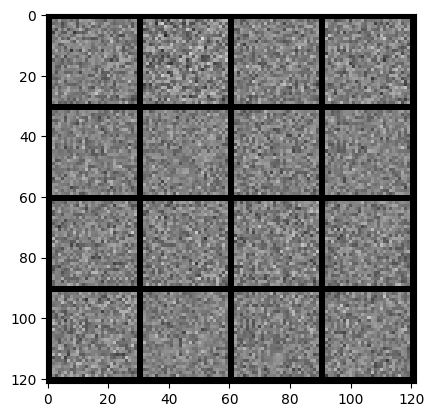

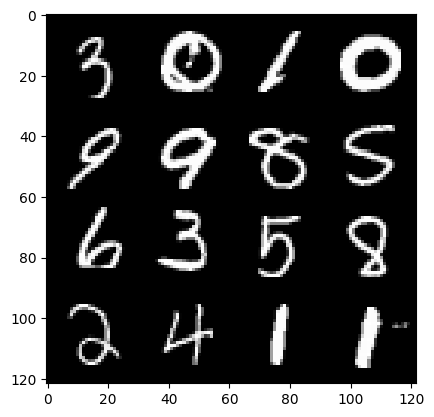

21: step 10200/ Gen loss : 7.099896178245546 / Disc Loss : 0.009469164812471724


  0%|          | 0/469 [00:00<?, ?it/s]

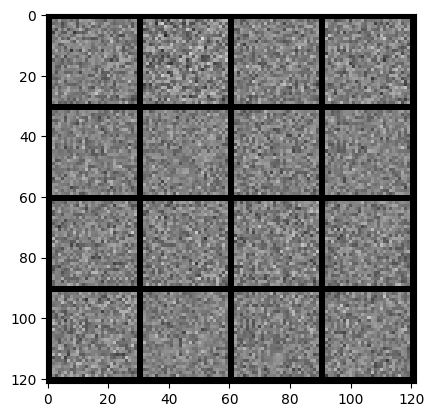

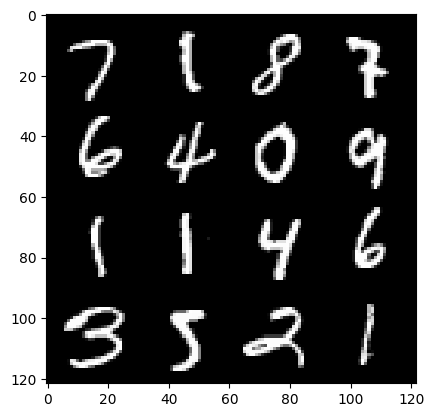

22: step 10500/ Gen loss : 7.852103447914124 / Disc Loss : 0.009881424525907886


  0%|          | 0/469 [00:00<?, ?it/s]

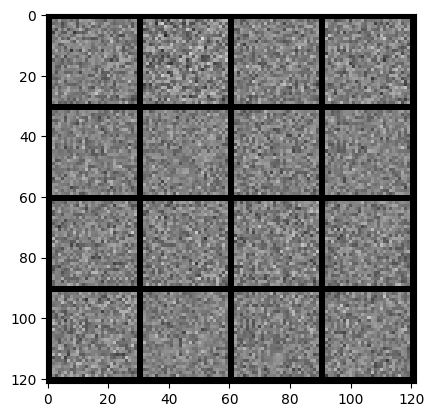

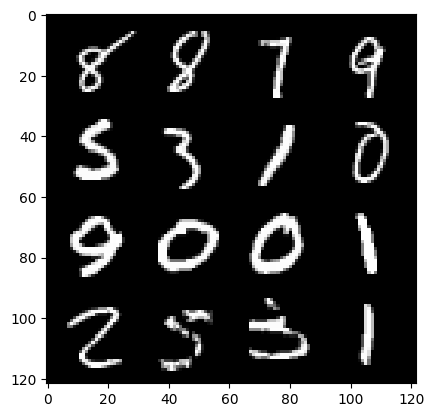

23: step 10800/ Gen loss : 7.300652136802668 / Disc Loss : 0.01311426761249701


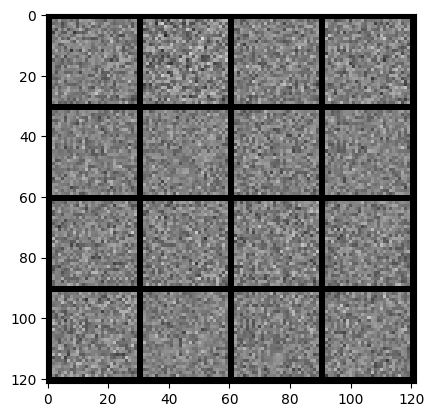

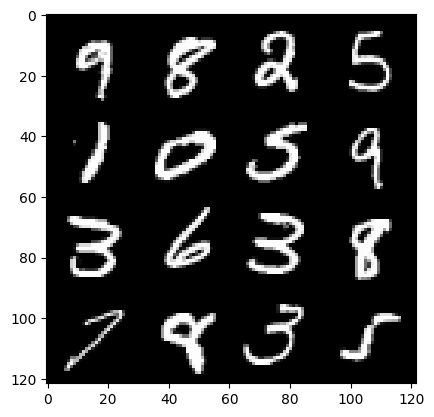

23: step 11100/ Gen loss : 6.6079667329788165 / Disc Loss : 0.011443501672862708


  0%|          | 0/469 [00:00<?, ?it/s]

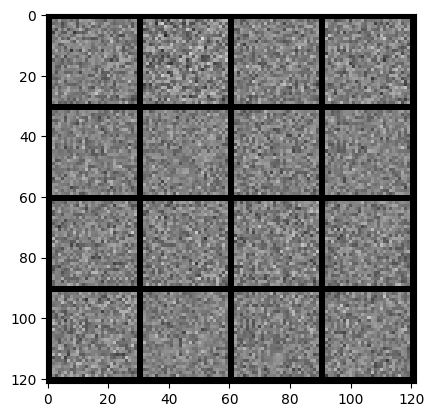

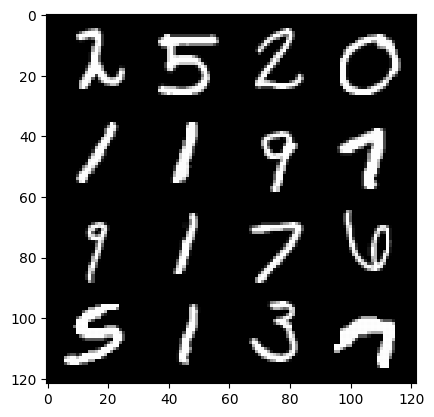

24: step 11400/ Gen loss : 6.873878744443256 / Disc Loss : 0.010435085641996317


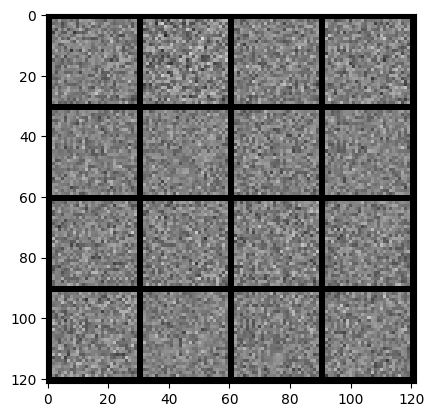

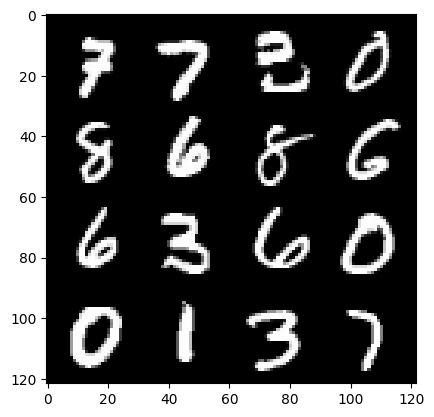

24: step 11700/ Gen loss : 7.501566627820331 / Disc Loss : 0.012619687352562326


  0%|          | 0/469 [00:00<?, ?it/s]

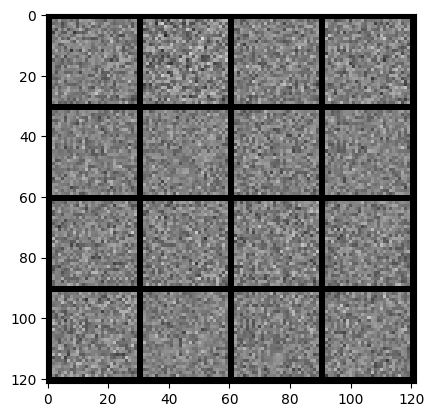

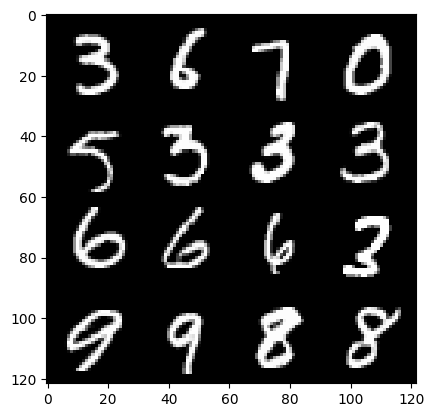

25: step 12000/ Gen loss : 7.512979400952652 / Disc Loss : 0.014674445545921714


  0%|          | 0/469 [00:00<?, ?it/s]

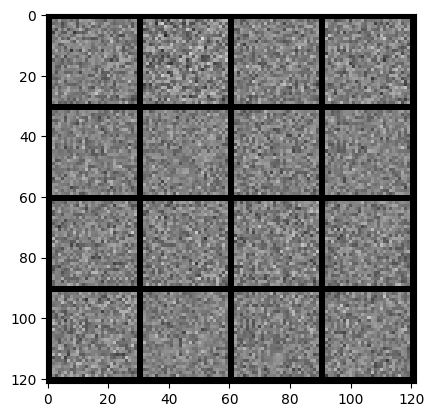

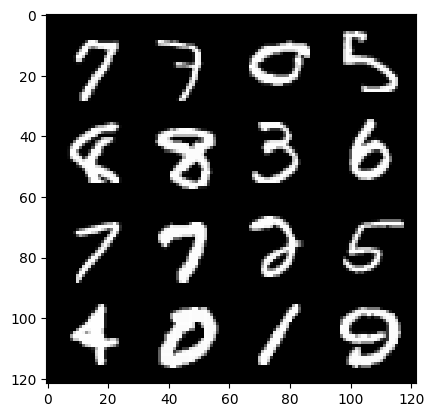

26: step 12300/ Gen loss : 7.115955168406167 / Disc Loss : 0.013939825842001784


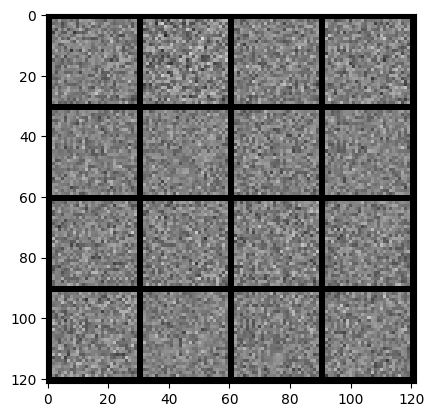

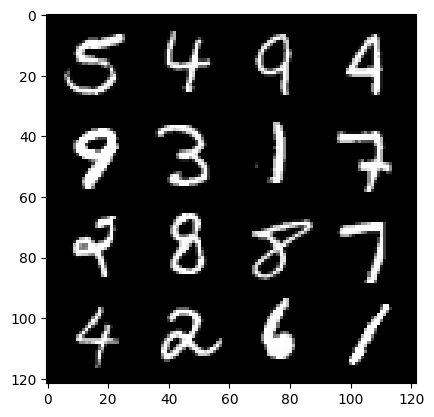

26: step 12600/ Gen loss : 6.9263689215977955 / Disc Loss : 0.013521405781308804


  0%|          | 0/469 [00:00<?, ?it/s]

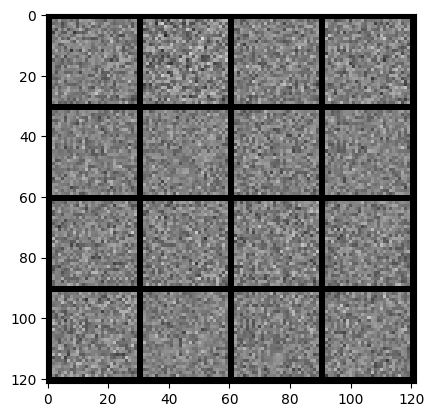

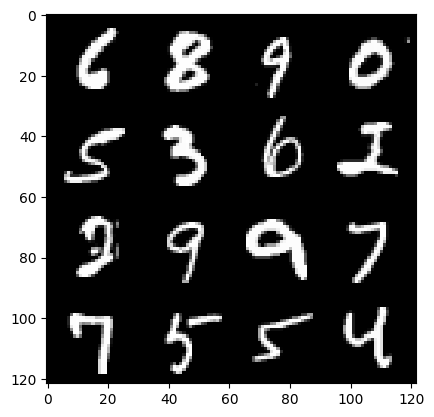

27: step 12900/ Gen loss : 6.799435337384542 / Disc Loss : 0.013935343146634596


  0%|          | 0/469 [00:00<?, ?it/s]

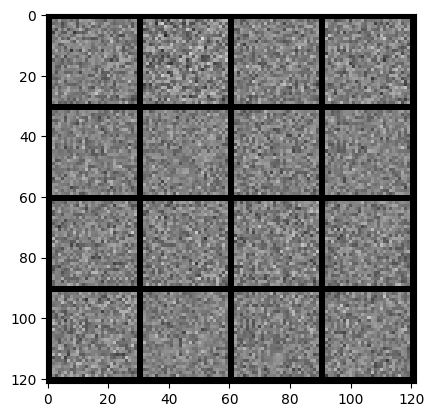

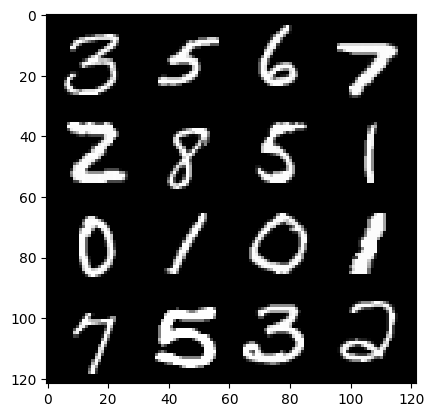

28: step 13200/ Gen loss : 6.880325771967569 / Disc Loss : 0.016095826306069885


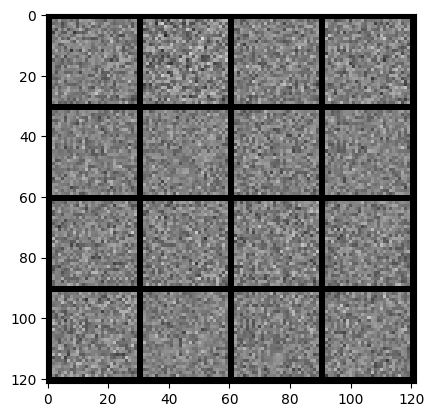

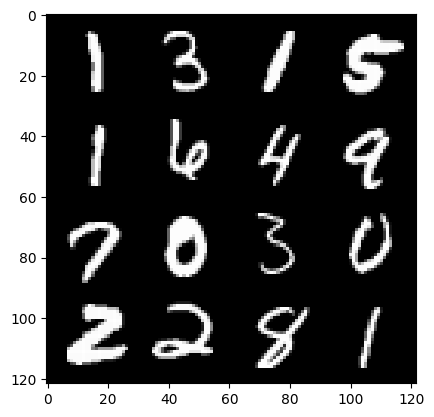

28: step 13500/ Gen loss : 7.117074081103001 / Disc Loss : 0.016553817251697175


  0%|          | 0/469 [00:00<?, ?it/s]

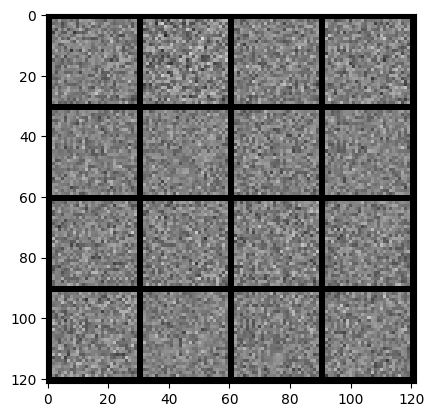

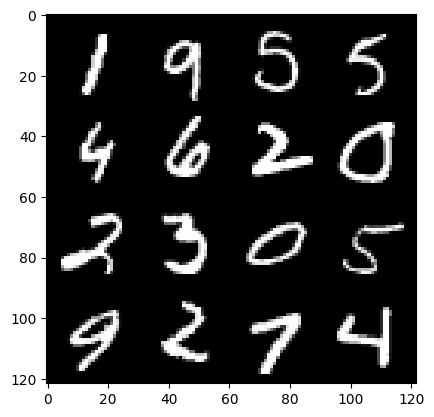

29: step 13800/ Gen loss : 6.596988232930498 / Disc Loss : 0.016755602334160364


  0%|          | 0/469 [00:00<?, ?it/s]

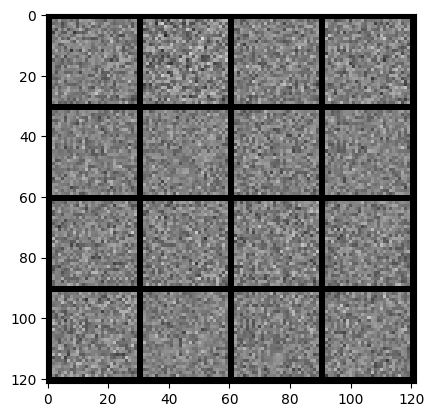

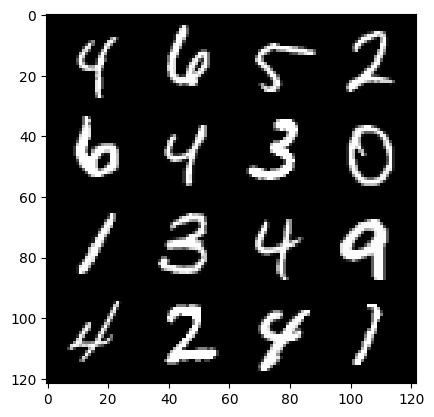

30: step 14100/ Gen loss : 7.06092102686564 / Disc Loss : 0.016179308241698883


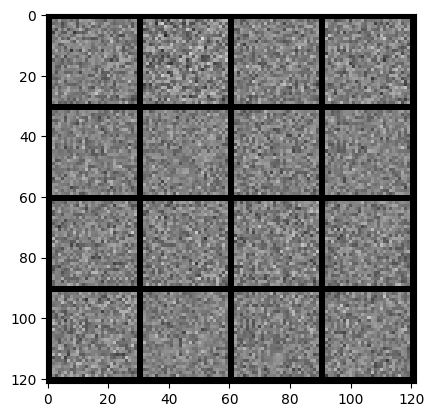

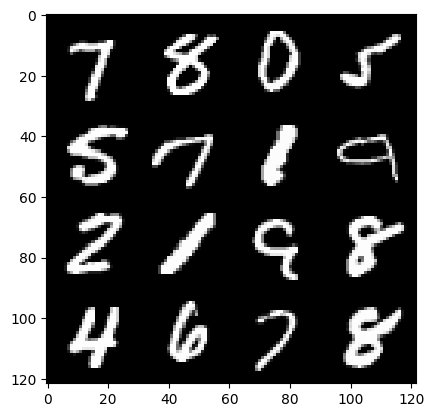

30: step 14400/ Gen loss : 6.710020411809289 / Disc Loss : 0.01506717478623614


  0%|          | 0/469 [00:00<?, ?it/s]

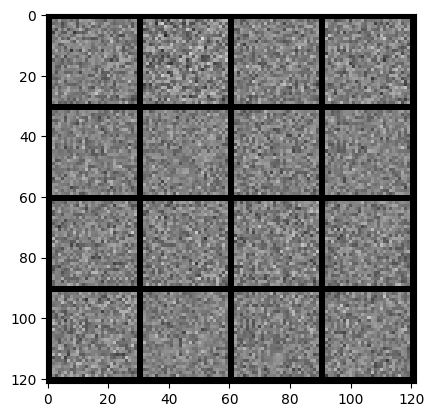

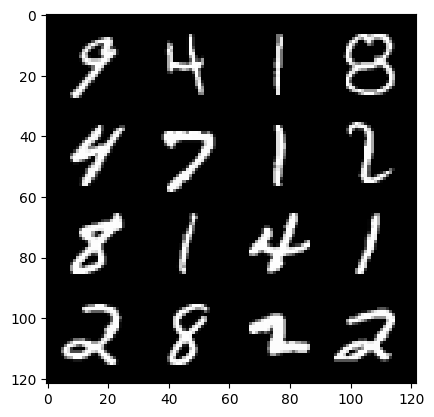

31: step 14700/ Gen loss : 6.834460824330643 / Disc Loss : 0.017441486044166003


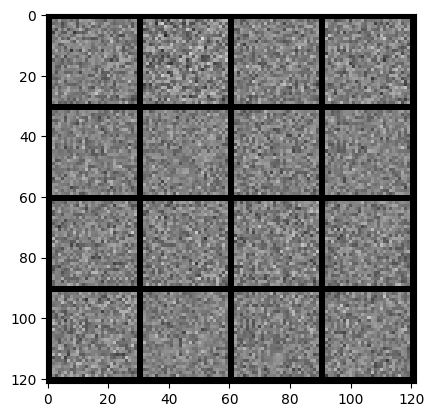

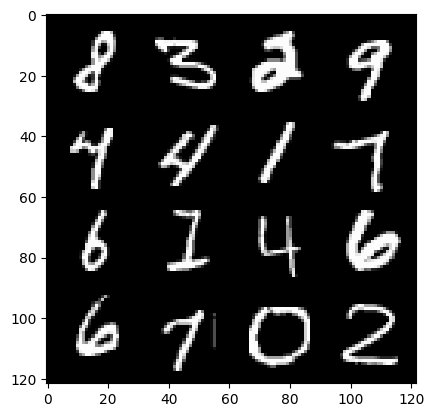

31: step 15000/ Gen loss : 6.74345252672831 / Disc Loss : 0.021126881940290325


  0%|          | 0/469 [00:00<?, ?it/s]

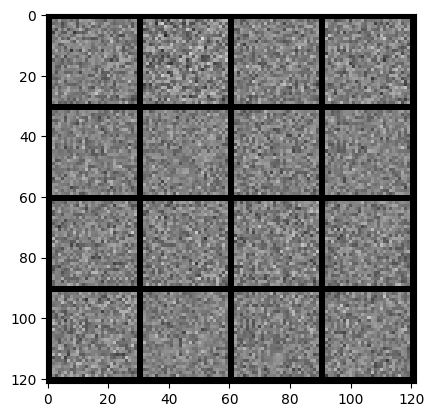

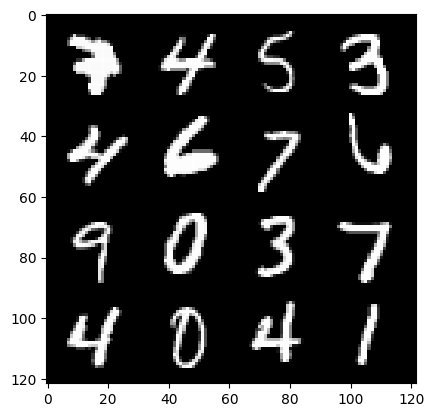

32: step 15300/ Gen loss : 6.846939924558004 / Disc Loss : 0.025101468257295586


  0%|          | 0/469 [00:00<?, ?it/s]

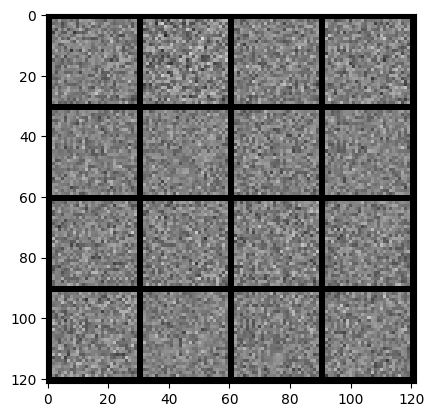

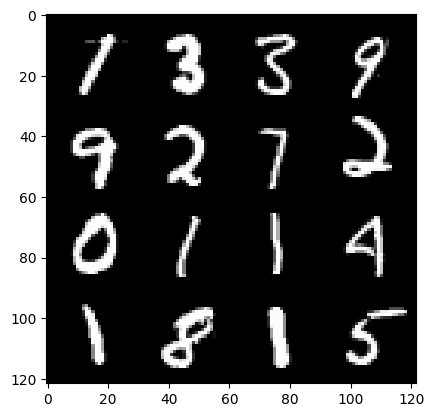

33: step 15600/ Gen loss : 6.7197525898615496 / Disc Loss : 0.024185051160554086


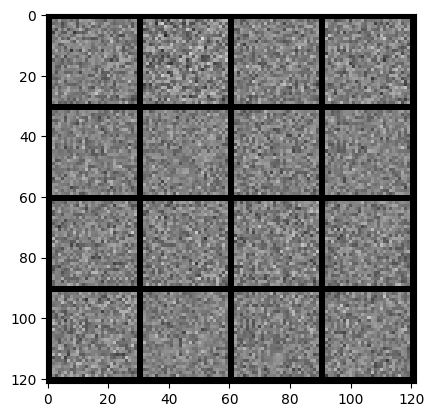

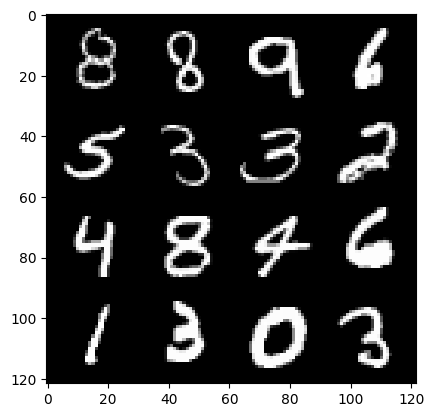

33: step 15900/ Gen loss : 6.65335939089457 / Disc Loss : 0.022852202649228277


  0%|          | 0/469 [00:00<?, ?it/s]

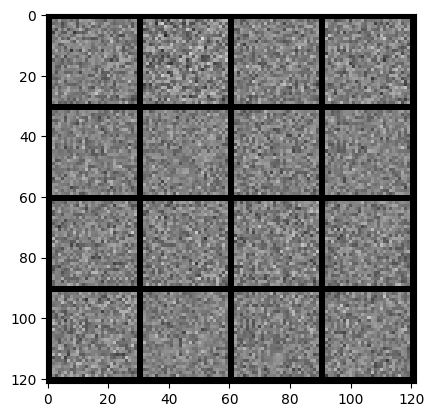

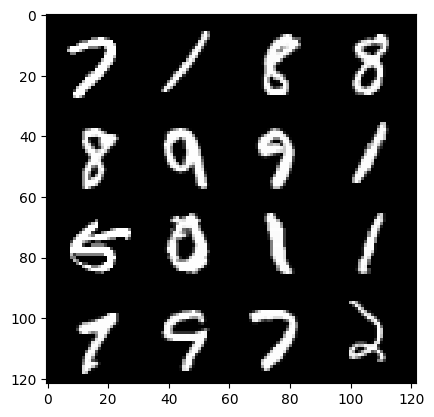

34: step 16200/ Gen loss : 6.8142656548818 / Disc Loss : 0.022095687109977006


KeyboardInterrupt: 

In [31]:
# 600000/128 = 469 steps in each epoch
# each step is going to process 128 images = size of the batch


for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator

    disc_opt.zero_grad()
    cur_bs= len(real) # mostly 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func, gen,disc,cur_bs,real,z_dim)

    disc_loss.backward(retain_graph= True)
    disc_opt.step() # to tweak parameters of discriminator


    ###generator

    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph= True)
    gen_opt.step()


    #Visualization

    mean_disc_loss += disc_loss.item()/info_step
    mean_gen_loss += gen_loss.item()/info_step

    if cur_step % info_step ==0 and cur_step>0: # at 300 steps
      fake_noise = gen_noise(cur_bs,z_dim)
      show(fake)
      show(real)

      print(f"{epoch}: step {cur_step}/ Gen loss : {mean_gen_loss} / Disc Loss : {mean_disc_loss}")
      mean_gen_loss , mean_disc_loss = 0,0

    cur_step+=1